In [6]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

In [7]:
true_news=pd.read_csv('True.csv')
false_news=pd.read_csv('Fake.csv')

In [8]:
true_news['label']=1
false_news['label']=0
news=true_news.append(false_news)
news.shape

(44898, 5)

In [9]:
import re
text=[]
for i in news['text']:
    text.append(i.split('- ', 1)[-1])
news['text']=text

In [12]:
features = news['text']
targets = news['label']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [14]:
import re
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
#         i = ' '.join([word for word in i.split() if word not in cachedStopWords])
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [16]:
max_vocab = 107000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [17]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [18]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          3424000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,494,401
Trainable params: 3,494,401
Non-trainable params: 0
______________________________________________

In [20]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_data=(X_train, y_train), batch_size=256, shuffle=True, callbacks=[early_stop])

Epoch 1/10
141/141 [==============================] - 280s 2s/step - loss: 0.6524 - accuracy: 0.5472 - val_loss: 0.4311 - val_accuracy: 0.8103
Epoch 2/10
141/141 [==============================] - 285s 2s/step - loss: 0.2684 - accuracy: 0.9129 - val_loss: 0.1504 - val_accuracy: 0.9577
Epoch 3/10
141/141 [==============================] - 285s 2s/step - loss: 0.1350 - accuracy: 0.9662 - val_loss: 0.0782 - val_accuracy: 0.9806
Epoch 4/10
141/141 [==============================] - 285s 2s/step - loss: 0.0812 - accuracy: 0.9810 - val_loss: 0.0491 - val_accuracy: 0.9871
Epoch 5/10
141/141 [==============================] - 267s 2s/step - loss: 0.0521 - accuracy: 0.9890 - val_loss: 0.0321 - val_accuracy: 0.9917
Epoch 6/10
141/141 [==============================] - 282s 2s/step - loss: 0.0353 - accuracy: 0.9932 - val_loss: 0.0231 - val_accuracy: 0.9943
Epoch 7/10
141/141 [==============================] - 280s 2s/step - loss: 0.0257 - accuracy: 0.9958 - val_loss: 0.0149 - val_accuracy: 0.9973

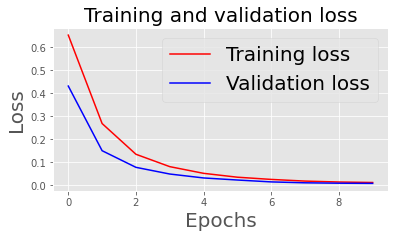

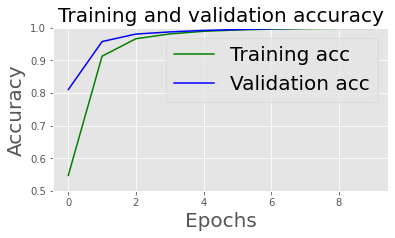

In [24]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(6,3))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(6,3))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [22]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model.save("model.h5")

In [27]:
binary_predictions=[]
predictions = model.predict(X_test)
for i in predictions:
    if(i<0.5):
        binary_predictions.append(0)
    else:
        binary_predictions.append(1)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, binary_predictions))

[[4671   51]
 [ 100 4158]]


In [30]:
target_names = ['False', 'True']
print(classification_report(y_test, binary_predictions, target_names=target_names))

              precision    recall  f1-score   support

       False       0.98      0.99      0.98      4722
        True       0.99      0.98      0.98      4258

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980

